![tinhatben](tinhatben_svg.png)

# Facial Landmarking using Neural Networks

This Python notebook has been written to partner with the [tinhatben blog post](http://www.tinhatben.com/2017/03/facial-landmarking-with-neural-networks/)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [1]:
# Imports
from tinhatbenbranding import TINHATBEN_GRAY, TINHATBEN_YELLOW, TINHATBEN_ORANGE, add_tinhatbendotcom
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import time

%matplotlib inline

## Examine the Data

The dataset we will be using throughout this tutorial is a series of 96 x 96 grayscale images that have been manually marked with 15 landmarks.  This dataset is a small sample of that provided during the [Kaggle Facial Keypoints Detection Competition](https://www.kaggle.com/c/facial-keypoints-detection/data); to ensure quick download and unnecessary complications in the tutorial only 1000 samples with all landmarks present are being used.  So let's have a look at the data...

In [2]:
all_data = pd.read_csv('training.csv')
number_of_samples = len(all_data)
print("Number of samples in the set: %d" % number_of_samples)

Number of samples in the set: 1000


### Extracting the images from the data set

In [3]:
all_data['Image'] = all_data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
images = np.vstack(all_data['Image'])
print("Shape of extracted images matrix: {}".format(images.shape))

Shape of extracted images matrix: (1000, 9216)


### Extracting the landmarks from the data set

We have 15 landmarks with $x$ and $y$ coordinates so we have 1000 $x$ 30 landmark data points

In [4]:
# Images are no longer required in the pandas dataframe, so remove
del all_data['Image']

coords = all_data.values
print("Shape of coordinates values {}".format(coords.shape))

Shape of coordinates values (1000, 30)


Finally we can have a look at the data set

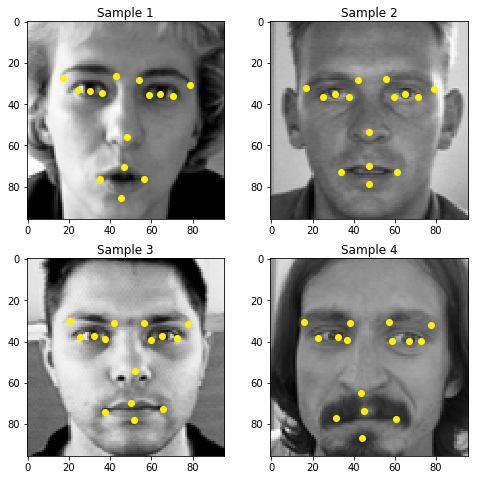

In [5]:
plt.figure(figsize=(8,8))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title('Sample %d' % i)
    plt.imshow(images[i].reshape((96, 96)), cmap='gray')
    lmrks = coords[i].reshape((-1, 2))
    plt.scatter(lmrks[:,0], lmrks[:,1], c=TINHATBEN_YELLOW)

Looking at the data when can see there are a number of different faces, with different facial expressions.  We can also see that some of the **ground truth** landmarks are not perfectly placed e.g the nose tip of Sample 4.

# Building the neural network model

If you are unfamiliar with the theory behind neural networks I would suggest reviewing the [tinhatben](www.tinhatben.com) posts on neural networks and backpropagation:
* [Part One](http://www.tinhatben.com/2016/09/neural-networks-and-backpropagation-part-one/)
* [Part Two](http://www.tinhatben.com/2016/09/neural-networks-and-backpropagation-part-two/)

The previous tutorials constructed neural networks using Python and numpy, our model in this tutorial will be constructed using the excellent [theano library](http://www.deeplearning.net/software/theano/).   Theano is used to create parametric models, we first need to define the mathematical equations without providing any actual variables.  Everything will be defined using symbolic variables known as **tensors**.

### Inputs to the model
As per above each image is 96 pixels x 96 pixels and we have 1000 of them.  To feed them into the network we will need to flatten each image into a vector; as such our matrix will return to a shape of 1000 x 9216.

So **we have 9216 input units ($n_{in}$)**

### The hidden layer to the model
To start with we will use **100 hidden units ($n_{hidden}$)** within the model.  This is one of the so-called **hyperparameters** of the neural network model and our choice of 50 is a first estimate.  We will examine what changing this value does to the performance of the network.

The hidden layer will use a $tanh$ non-linearity activation function with bias weights.  

$$g(x) = tanh(Wx + b)$$

The weights will be initialised with random values normally sampled between $$\pm\frac{1}{\sqrt{n_{in} + n_{hidden}}}$$

### Output layer to the model
We have 15 landmarks with x and y coordinates which we need to predict so we have an output layer with **30 units** with bias.  As this is not a classification problem, but rather a regression problem the output layer will have a linear output i.e. no nonlinearity.

The weights will be initialised with random values normally sampled between $$\pm\frac{1}{\sqrt{n_{hidden} + n_{out}}}$$

So let's build the model using theano

In [6]:
#####################################################################################################
# Modify this variable and see the effect on training
n_hidden = 100
#####################################################################################################

In [7]:
# The input layer is just each of the images flattened so
input_layer = T.matrix('x')

n_in = images.shape[1] # 9216
n_out = coords.shape[1] # 30

# Construct hidden layer

# Initialisation bounds
W_bounds = np.sqrt(1 / (n_in + n_hidden))

rng = np.random.RandomState(int(time.time()))
W_hidden = theano.shared(
    np.asarray(
        rng.uniform(low=-W_bounds, high=W_bounds, size=(n_in, n_hidden))
    ),
    borrow=True
)
b_hidden = theano.shared(
    np.asarray(
        rng.uniform(low=-W_bounds, high=W_bounds, size=(n_hidden))
    ),
    borrow=True
)

hidden_activations = T.tanh(T.dot(input_layer, W_hidden) + b_hidden)

# Construct output layer

# Initialisation bounds
W_bounds = np.sqrt(1 / (n_hidden + n_out))

rng = np.random.RandomState(int(time.time()))
W_output = theano.shared(
    np.asarray(
        rng.uniform(low=-W_bounds, high=W_bounds, size=(n_hidden, n_out))
    ),
    borrow=True
)
b_output = theano.shared(
    np.asarray(
        rng.uniform(low=-W_bounds, high=W_bounds, size=(n_out))
    ),
    borrow=True
)

output = T.dot(hidden_activations, W_output) + b_output

# Training the model
Now we have defined the model, we need to train it.  To do this we first must centre and scale the data to have a mean of 0 and standard deviation of 1.  We are then going to use simple cross validation, setting aside 70% of the available 1000 samples to adjust the weights of the model and the remaining 30% to check its performance.  We are going to randomly split the available data into training and validation samples.

In [8]:
# Scale the data
image_max = np.max(images)
images = images / image_max
image_mean = np.mean(images)
images -= image_mean

print("Images mean %0.2f, max %0.2f" % (np.mean(images), np.max(images)))

coords_max = np.max(coords)
coords = coords / coords_max
coords_mean = np.mean(coords)
coords -= coords_mean

print("Coords mean %0.2f, max %0.2f" % (np.mean(coords), np.max(coords)))

# Splitting the data

images_train, images_valid, coords_train, coords_valid = train_test_split(images, coords, test_size=0.3)
print('training images shape {}'.format(images_train.shape))
print('training coords shape {}'.format(coords_train.shape))

print('valid images shape {}'.format(images_valid.shape))
print('valid coords shape {}'.format(coords_valid.shape))

Images mean 0.00, max 0.54
Coords mean -0.00, max 0.50
training images shape (700, 9216)
training coords shape (700, 30)
valid images shape (300, 9216)
valid coords shape (300, 30)


## Cost function
The cost function provides a measure of error for the model, i.e. how close is the model to the ground truth?  The goal of the training process is to determine the model that best matches the the validation set i.e. minimises the result of the cost function.  As this is a regression problem we are going to use the mean squared error (MSE) cost function.

$$cost=MSE=\frac{1}{n}\Sigma(Y_{prediction} - Y_{truth})^2$$

In [9]:
ground_truth = T.matrix()

cost = T.mean((output - ground_truth) ** 2)

## Gradient Descent
We are going to use basic gradient descent without momentum or any other additions.  Again, for more information on this see previous blog posts.  This is one of the great things about theano, its architecture allows us to quickly and easily perform backpropagation and gradient descent.  To start with, we are going to use a learning rate $\eta=0.01$.

In [10]:
weights = [W_hidden, b_hidden, W_output, b_output]
grads = T.grad(cost, weights)  # one line backpropagation !!!!!!
eta = 0.01

# Execute the gradient descent update
grad_desc = [
    (param, param - eta * grad) for param, grad in zip(weights, grads)
]

# Build the training and validation set functions
training_func = theano.function(
    inputs=[input_layer, ground_truth],
    outputs=cost,
    updates=grad_desc,
)

validation_func = theano.function(
    inputs=[input_layer, ground_truth],
    outputs=cost,
)

predict = theano.function(
    inputs=[input_layer],
    outputs=output
)

# Execute Training
Now we are finally going to train the model, again nothing fancy here.  We are simply going to run 750 iterations of gradient descent, recording the training and validation error as we go along.  At the end of the 750 iterations we will report the minimum validation error for the model.

**!!! WARNING THIS TRAINING PROCESS MAY TAKE SOME TIME !!!!**

In [11]:
training_error = []
validation_error = []
for i in range(750):
    training_error.append(training_func(images_train, coords_train))
    validation_error.append(validation_func(images_valid, coords_valid))
    
min_val_err = min(validation_error)
idx = validation_error.index(min_val_err)
print("Minimum validation error %E @ %i" % (min_val_err, idx))
print("Training error @ %i: %E" % (idx, training_error[idx]))

Minimum validation error 3.124496E-03 @ 749
Training error @ 749: 2.727863E-03


What does this training look like if we were to plot the errors?

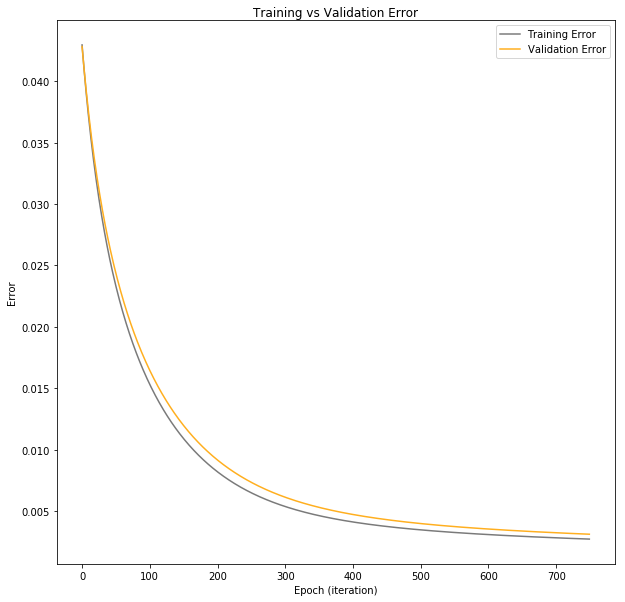

In [16]:
plt.figure(figsize=(10,10))
plt.plot(training_error, c=TINHATBEN_GRAY, label='Training Error')
plt.plot(validation_error, c=TINHATBEN_ORANGE, label='Validation Error')
plt.title('Training vs Validation Error')
plt.xlabel('Epoch (iteration)')
plt.ylabel('Error')
plt.legend()

### How Does Our Model Perform?
So how does a model perform?  Let's visualise the predictions on the images against the ground truths  

In [13]:
valid_predictions = predict(images_valid[:4])
valid_predictions += coords_mean
valid_predictions *= coords_max

true_locations = coords_valid[:4]
true_locations += coords_mean
true_locations *= coords_max

# Return the images to original mean and scale
valid_images_display = images_valid[:4] + image_mean
valid_images_display *= image_max

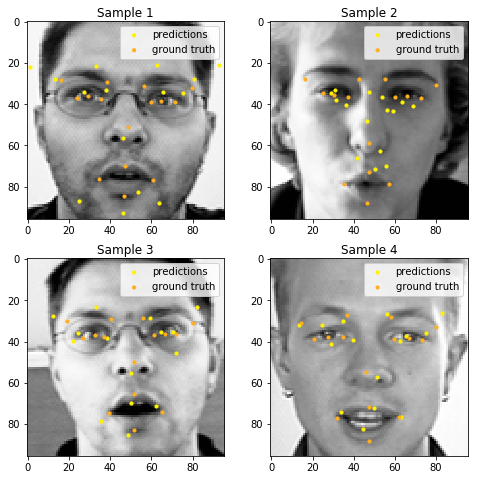

In [14]:
plt.figure(figsize=(8,8))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title('Sample %d' % i)
    plt.imshow(valid_images_display[i-1].reshape((96, 96)), cmap='gray')
    lmrks = valid_predictions[i-1].reshape((-1, 2))
    lmrks_true = true_locations[i-1].reshape((-1, 2))
    plt.scatter(lmrks[:,0], lmrks[:,1], c=TINHATBEN_YELLOW, label='predictions', s=10)
    plt.scatter(lmrks_true[:,0], lmrks_true[:,1], c=TINHATBEN_ORANGE, label='ground truth', s=10)
    plt.legend()

With $n_{hidden} = 100$ we can see almost no difference between the training and validation error.  After 500 epochs the training error is continuing to decrease and about the same as the validation error. By using a smaller number of hidden units we have avoided a problem known as overfitting, where the network is starting to memorise the training set and reduces the ability of it to generalise to new samples it hasn't seen before. What happens if we reduce $n_{hidden}$ to 50 or increase it to 500?  What about if you increase the number of training epochs?  Try and see!

What we can see in the images is that the predictions are ok, but not really that great.  Do they improve by changing some of the parameters such as number of hidden units or epochs?  In future posts we will look at improving this result using other techniques and more advanced methods such as deep networks.

In [15]:
# End of notebook